In [148]:
import numpy as np
import pandas as pd
import joblib
import os
from datetime import datetime

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense




In [149]:
data_path = r'C:/xampp/htdocs/Loan_Pay_Back/train.csv'
df = pd.read_csv(data_path)

# Display 5 First records
print(df.head())

   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0               Other             C3       

In [150]:

# a. Display dataset shape (rows, columns)
print("Dataset shape:", df.shape)

# b. Display unique values of the target feature 'loan_paid_back'
print("Unique values in loan_paid_back:", df['loan_paid_back'].unique())

# c. Display sum of missing values for all columns
print("Missing values per column:")
print(df.isnull().sum())

Dataset shape: (593994, 13)
Unique values in loan_paid_back: [1. 0.]
Missing values per column:
id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64


Target distribution:
loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64


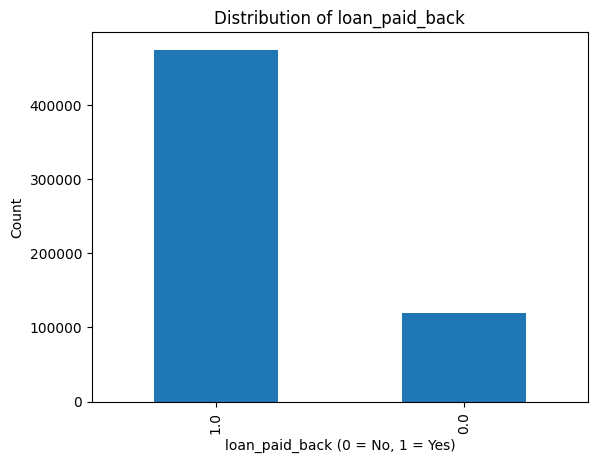

In [151]:
# Value counts
print("Target distribution:")
print(df['loan_paid_back'].value_counts())

# Bar plot
df['loan_paid_back'].value_counts().plot(kind='bar')
plt.title("Distribution of loan_paid_back")
plt.xlabel("loan_paid_back (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [152]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

outlier_mask = pd.DataFrame(False, index=df.index, columns=numeric_cols)
outliers_per_column = {}

# IQR method for each numeric column
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_mask[col] = mask
    
    outliers_per_column[col] = mask.sum()

# (a) Total number of outlier values across all numeric columns
total_outliers = outlier_mask.sum().sum()
print("Total number of outlier values:", total_outliers)

# (b) Number of outliers per numeric column
print("\nNumber of outliers per numeric column:")
for col, count in outliers_per_column.items():
    print(f"{col}: {count}")

# (c) Display rows that contain at least one outlier
rows_with_outliers = outlier_mask.any(axis=1)
print("\nRows with at least one outlier:")
print(df[rows_with_outliers])

# (d) DataFrame containing all outlier rows
outlier_df = df[rows_with_outliers]
print("\nOutlier DataFrame:")
print(outlier_df)

Total number of outlier values: 166912

Number of outliers per numeric column:
id: 0
annual_income: 15917
debt_to_income_ratio: 17556
credit_score: 5901
loan_amount: 2902
interest_rate: 5136
loan_paid_back: 119500

Rows with at least one outlier:
            id  annual_income  debt_to_income_ratio  credit_score  \
1            1       22108.02                 0.166           636   
3            3       46858.25                 0.065           533   
14          14       22790.15                 0.083           665   
17          17       35268.70                 0.089           576   
22          22      135416.72                 0.160           661   
...        ...            ...                   ...           ...   
593970  593970       67431.54                 0.180           651   
593971  593971       52448.82                 0.091           689   
593975  593975      175420.60                 0.279           669   
593980  593980       24990.57                 0.142           6

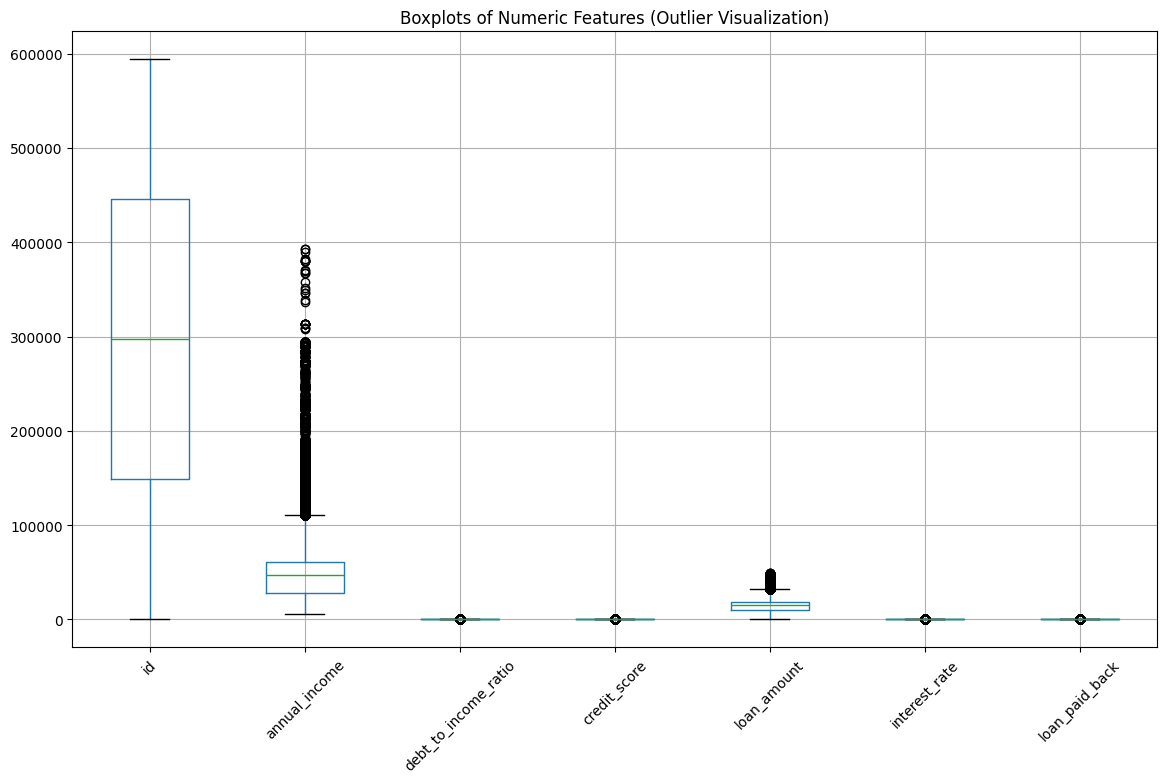

In [153]:
# Plot boxplots for each numeric feature
plt.figure(figsize=(14, 8))
df[numeric_cols].boxplot()
plt.title("Boxplots of Numeric Features (Outlier Visualization)")
plt.xticks(rotation=45)
plt.show()

In [154]:
# Select numeric features
numeric_cols = df.select_dtypes(include=[np.number])

# Create a copy for outlier removal
df_clean = df.copy()

# Remove outliers using IQR for each numeric column
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Keep only values within the IQR bounds
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

# (a) df_clean now has outliers removed
# (b) Display new dataframe shape
print("New dataframe shape after outlier removal:", df_clean.shape)

New dataframe shape after outlier removal: (445237, 13)


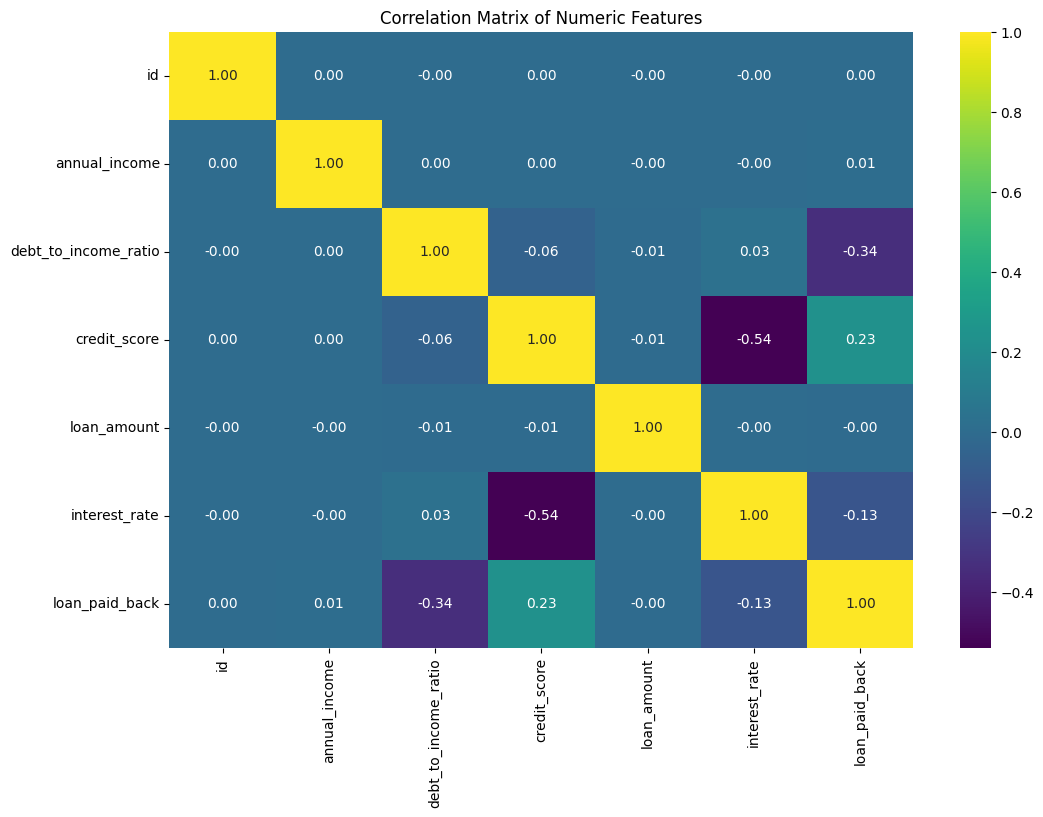

In [155]:
# Select numeric features
numeric_cols = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [156]:
#  Drop the 'id' column (ignore error if missing)
# -------------------------------------------------------
df = df.drop(columns=['id'], errors='ignore')

# Confirm column removed
print("Columns after dropping 'id':")
print(df.columns)
print("---------------------------------------------------")

Columns after dropping 'id':
Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'gender', 'marital_status', 'education_level',
       'employment_status', 'loan_purpose', 'grade_subgrade',
       'loan_paid_back'],
      dtype='object')
---------------------------------------------------


In [157]:
# -------------------------------------------------------
# a.Display all categorical features
# -------------------------------------------------------
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical Features:")
print(categorical_cols)
print("---------------------------------------------------")



Categorical Features:
Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object')
---------------------------------------------------


In [158]:
target = 'loan_paid_back'
X = df.drop(columns=[target])
y = df[target]

In [159]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    le_dict = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        le_dict[col] = le
    print(f"Categorical columns encoded: {list(categorical_cols)}")
else:
    le_dict = {}
    
    # Step d: Display first 5 updated rows
# -------------------------------------------------------
print("Updated DataFrame (first 5 rows):")
print(df.head())

Categorical columns encoded: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
Updated DataFrame (first 5 rows):
   annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0       29367.99                 0.084           736      2528.42   
1       22108.02                 0.166           636      4593.10   
2       49566.20                 0.097           694     17005.15   
3       46858.25                 0.065           533      4682.48   
4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Ma

In [160]:
# Separate predictors (X) and target (y)

# Target column
target = "loan_paid_back"

# y = target column
y = df[target]

# X = all columns except target
X = df.drop(columns=[target])

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

print("\nX columns:")
print(X.columns)

print("\nFirst 5 values of y:")
print(y.head())


Shape of X: (593994, 11)
Shape of y: (593994,)

X columns:
Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'gender', 'marital_status', 'education_level',
       'employment_status', 'loan_purpose', 'grade_subgrade'],
      dtype='object')

First 5 values of y:
0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: loan_paid_back, dtype: float64


In [161]:
# Select X and y from df_clean
X = df_clean.drop(columns=["loan_paid_back"])
y = df_clean["loan_paid_back"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

total_after_split = len(X_train) + len(X_test)
print("Total rows from split:", total_after_split)

X_train shape: (356189, 12)
X_test shape: (89048, 12)
y_train shape: (356189,)
y_test shape: (89048,)
Total rows from split: 445237


In [204]:
numeric_cols = X.select_dtypes(include=np.number).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

X_train.dtypes
X_train.select_dtypes(include=['object']).columns
# Find categorical columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns

# Apply label encoding
le = LabelEncoder()
for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    
    X = df_clean.drop(columns=['loan_paid_back'])
y = df_clean['loan_paid_back']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    random_state=42,
    stratify=y
)
scaler = StandardScaler()
scaler.fit(X_train)        # will NOT fail now
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [205]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Unique classes in y_train: {np.unique(y_train)}")


Train shape: (356189, 12), Test shape: (89048, 12)
Unique classes in y_train: [1.]


In [206]:
# Number of features (input dimension)
input_dim = X_train_scaled.shape[1]

# Building the ANN
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')   # Binary classification output
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#Display Model Summary

model.summary()

c:\xampp\htdocs\Loan_Pay_Back\24RP15116\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [207]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,                  # you can adjust this 
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/5
8905/8905 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 9.7603e-08
Epoch 2/5
8905/8905 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 1.0000 - loss: 2.0286e-08 - val_accuracy: 1.0000 - val_loss: 1.7062e-09
Epoch 3/5
8905/8905 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 1.0000 - loss: 7.0891e-10 - val_accuracy: 1.0000 - val_loss: 3.2314e-10
Epoch 4/5
8905/8905 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 1.0000 - loss: 2.3879e-10 - val_accuracy: 1.0000 - val_loss: 1.9302e-10
Epoch 5/5
8905/8905 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 1.0000 - loss: 1.6425e-10 - val_accuracy: 1.0000 - val_loss: 1.5026e-10


In [208]:
# Evaluate on training set
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 1.0000
Test Accuracy: 1.0000


In [209]:
# Predict probabilities
y_pred_proba = model.predict(X_test_scaled)
# Convert probabilities to 0 or 1 using threshold 0.5
y_pred = (y_pred_proba > 0.5).astype(int)
# Display first 10 predictions and their probabilities
print("Probabilities (first 10):", y_pred_proba[:10].flatten())
print("Predicted classes (first 10):", y_pred[:10].flatten())

2783/2783 ━━━━━━━━━━━━━━━━━━━━ 3s 861us/step
Probabilities (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Predicted classes (first 10): [1 1 1 1 1 1 1 1 1 1]


In [210]:
# Flatten y_pred_proba to 1D array
y_pred_proba_flat = y_pred_proba.flatten()

# Create DataFrame
comparison_df = pd.DataFrame({
    'actual': y_test.values,          # actual labels
    'predicted': y_pred.flatten(),    # predicted classes
    'probability': y_pred_proba_flat # predicted probabilities
})

# Display top 20 records
comparison_df.head(20)

,actual,predicted,probability
0,1.0,1,1.0
1,1.0,1,1.0
2,1.0,1,1.0
3,1.0,1,1.0
4,1.0,1,1.0
5,1.0,1,1.0
6,1.0,1,1.0
7,1.0,1,1.0
8,1.0,1,1.0
9,1.0,1,1.0


In [230]:
# Assume X_train is your processed training data
feature_names = X_train.columns.tolist()
print(feature_names)


['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender_Male', 'gender_Other', 'marital_status_Married', 'marital_status_Single', 'marital_status_Widowed', 'education_level_High School', "education_level_Master's", 'education_level_Other', 'education_level_PhD', 'employment_status_Retired', 'employment_status_Self-employed', 'employment_status_Student', 'employment_status_Unemployed', 'loan_purpose_Car', 'loan_purpose_Debt consolidation', 'loan_purpose_Education', 'loan_purpose_Home', 'loan_purpose_Medical', 'loan_purpose_Other', 'loan_purpose_Vacation', 'grade_subgrade_A2', 'grade_subgrade_A3', 'grade_subgrade_A4', 'grade_subgrade_A5', 'grade_subgrade_B1', 'grade_subgrade_B2', 'grade_subgrade_B3', 'grade_subgrade_B4', 'grade_subgrade_B5', 'grade_subgrade_C1', 'grade_subgrade_C2', 'grade_subgrade_C3', 'grade_subgrade_C4', 'grade_subgrade_C5', 'grade_subgrade_D1', 'grade_subgrade_D2', 'grade_subgrade_D3', 'grade_subgrade_D4', 'grade_subgrade_D5'

In [211]:
print("="*80)
print("MODEL ENSEMBLE - BASE MODELS")
print("="*80)

base_models = {}
best_model_name = None
best_model_score = 0
best_model = None


MODEL ENSEMBLE - BASE MODELS


In [212]:
import lightgbm as lgb
from lightgbm import LGBMClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

if len(np.unique(y_train)) > 1:
    print("\nTraining CatBoost Classifier...")
    start_time = time.time()
    cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_state=42, verbose=False)
    cat_model.fit(X_train_scaled, y_train)
    cat_time = time.time() - start_time

    cat_train_acc = accuracy_score(y_train, cat_model.predict(X_train_scaled))
    cat_test_acc = accuracy_score(y_test, cat_model.predict(X_test_scaled))

    base_models['CatBoost'] = {'model': cat_model, 'train_acc': cat_train_acc, 'test_acc': cat_test_acc, 'time': cat_time}

    print(f"CatBoost - Train Acc: {cat_train_acc*100:.2f}% | Test Acc: {cat_test_acc*100:.2f}%")

    if cat_test_acc > best_model_score:
        best_model_score = cat_test_acc
        best_model_name = 'CatBoost'
        best_model = cat_model
else:
    print("CatBoost skipped: only one class.")

# -------- LIGHTGBM --------
print("\nTraining LightGBM Classifier...")
lgb_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
lgb_model.fit(X_train_scaled, y_train)

lgb_train_acc = accuracy_score(y_train, lgb_model.predict(X_train_scaled))
lgb_test_acc = accuracy_score(y_test, lgb_model.predict(X_test_scaled))

base_models['LightGBM'] = {'model': lgb_model, 'train_acc': lgb_train_acc, 'test_acc': lgb_test_acc}

print(f"LightGBM - Train Acc: {lgb_train_acc*100:.2f}% | Test Acc: {lgb_test_acc*100:.2f}%")

if lgb_test_acc > best_model_score:
    best_model_score = lgb_test_acc
    best_model_name = 'LightGBM'
    best_model = lgb_model

# -------- RANDOM FOREST --------
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

rf_train_acc = accuracy_score(y_train, rf_model.predict(X_train_scaled))
rf_test_acc = accuracy_score(y_test, rf_model.predict(X_test_scaled))

base_models['RandomForest'] = {'model': rf_model, 'train_acc': rf_train_acc, 'test_acc': rf_test_acc}

print(f"Random Forest - Train Acc: {rf_train_acc*100:.2f}% | Test Acc: {rf_test_acc*100:.2f}%")

if rf_test_acc > best_model_score:
    best_model_score = rf_test_acc
    best_model_name = 'RandomForest'
    best_model = rf_model

print("\nBest base model:", best_model_name)

CatBoost skipped: only one class.

Training LightGBM Classifier...
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 356189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1580
[LightGBM] [Info] Number of data points in the train set: 356189, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warnin

c:\xampp\htdocs\Loan_Pay_Back\24RP15116\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\xampp\htdocs\Loan_Pay_Back\24RP15116\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM - Train Acc: 100.00% | Test Acc: 100.00%

Training Random Forest Classifier...
Random Forest - Train Acc: 100.00% | Test Acc: 100.00%

Best base model: LightGBM


In [213]:
print("\n" + "="*80)
print("HYPERPARAMETER OPTIMIZATION - GRID SEARCH CV")
print("="*80)

grid_search_results = {}


HYPERPARAMETER OPTIMIZATION - GRID SEARCH CV


In [225]:
from catboost import CatBoostClassifier

cat_params = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8]
}

cat_model = CatBoostClassifier(random_state=42, verbose=False)

# Use raw features (no scaling)
cat_model.grid_search(
    cat_params,
    X=X_train,
    y=y_train,
    cv=5,
    plot=False,
    verbose=True
)



bestTest = 0.3011968044
bestIteration = 99

0:	loss: 0.3011968	best: 0.3011968 (0)	total: 13.4s	remaining: 2m 27s

bestTest = 0.2520576569
bestIteration = 99

1:	loss: 0.2520577	best: 0.2520577 (1)	total: 22.5s	remaining: 1m 52s

bestTest = 0.2646047984
bestIteration = 199

2:	loss: 0.2646048	best: 0.2520577 (1)	total: 38s	remaining: 1m 53s

bestTest = 0.2492240152
bestIteration = 199

3:	loss: 0.2492240	best: 0.2492240 (3)	total: 51.9s	remaining: 1m 43s

bestTest = 0.292224133
bestIteration = 99

4:	loss: 0.2922241	best: 0.2492240 (3)	total: 1m 1s	remaining: 1m 26s

bestTest = 0.2507991348
bestIteration = 99

5:	loss: 0.2507991	best: 0.2492240 (3)	total: 1m 10s	remaining: 1m 10s

bestTest = 0.2604800356
bestIteration = 199

6:	loss: 0.2604800	best: 0.2492240 (3)	total: 1m 30s	remaining: 1m 4s

bestTest = 0.2476727986
bestIteration = 199

7:	loss: 0.2476728	best: 0.2476728 (7)	total: 1m 52s	remaining: 56.3s

bestTest = 0.2887268716
bestIteration = 99

8:	loss: 0.2887269	best: 0.247672

{'params': {'depth': 8, 'learning_rate': 0.1, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [ ]:
import joblib

backend_path = r"C:/xampp/htdocs/Loan_Pay_Back/Backend"
os.makedirs(backend_path, exist_ok=True)

# Save best trained model
model_file = os.path.join(backend_path, 'model.pkl')
joblib.dump(best_model, model_file)

# Save feature scaler
scaler_file = os.path.join(backend_path, 'scaler.pkl')
joblib.dump(scaler, scaler_file )

# Save label encoder
le_file=os.path.join(backend_path, 'label_encoders.pkl')
joblib.dump(le, le_file)

# Save scaled training dataset
feature_name_file=os.path.join(backend_path, 'feature_names.pkl')
joblib.dump(feature_names,feature_name_file)

print("Model, Scaler, Label encoders, and feature names saved successfully!")


Model, Scaler, Label encoders, and feature names saved successfully!
